In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import math

data = pd.read_csv('SCADA-FINAL.csv')
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y-%m-%d %H:%M:%S')
data.set_index('Timestamp', inplace=True)

data.drop(columns=['day_sin', 'day_cos', 'D2_TEMPERATURE', 'Q-influent_MGD'], inplace=True)

data.columns


Index(['D1_TEMPERATURE', 'Q-PS_MGD', 'Q-TWAS_GPM', 'V-Boiler_FT3', 'H-HSW_ft',
       'H-Dig1_FT', 'H-Dig2_FT', 'Biogas_burner', 'Biogas_boiler', 'Q-HSW_GPM',
       'Biogas_prev_hour_avg', 'hour_sin', 'hour_cos', 'H-Dig1-deriv_FTpermin',
       'H-Dig2-deriv_FTpermin', 'V-burner_FT3-2', 'Q-PS_MGD_prev_24h',
       'Q-TWAS_GPM_prev_24h', 'Q-HSW_GPM_prev_24h', 'Biogas_prev_24h',
       'Biogas_prev_24h_1', 'Biogas_prev_24h_2', 'Biogas_prev_24h_3',
       'Biogas_prev_24h_4', 'Q-HSW_GPM_prev_24h_1', 'Q-HSW_GPM_prev_24h_2',
       'Q-HSW_GPM_prev_24h_3', 'Q-HSW_GPM_prev_24h_4', 'Q-PS_MGD_prev_24h_1',
       'Q-PS_MGD_prev_24h_2', 'Q-PS_MGD_prev_24h_3', 'Q-PS_MGD_prev_24h_4',
       'Q-TWAS_GPM_prev_24h_1', 'Q-TWAS_GPM_prev_24h_2',
       'Q-TWAS_GPM_prev_24h_3', 'Q-TWAS_GPM_prev_24h_4', 'Forecast'],
      dtype='object')

In [2]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

x_train, x_test, y_train, y_test = train_test_split(
    data.drop('Forecast', axis=1), data['Forecast'], test_size=0.2,
    shuffle=False)

# Initialize scaler object
scaler = StandardScaler()

# Fit the scaler on the training dataset, but we have to exclude the sine and cosine terms
scaler.fit(x_train)

# Transform the training and testing dataset
x_train_s = pd.DataFrame(scaler.transform(x_train), index=x_train.index)
x_test_s = pd.DataFrame(scaler.transform(x_test), index=x_test.index)

# Add the column names back
x_train_s.columns = x_train.columns
x_test_s.columns = x_test.columns

# Check to make sure everything looks right
x_train_s

D1_TEMPERATURE  Q-PS_MGD  Q-TWAS_GPM  V-Boiler_FT3  \
Timestamp                                                                 
2022-03-23 00:00:00       -0.568071 -0.191843   -0.339807      3.033354   
2022-03-23 00:01:00       -0.469175  5.150879   -0.339807     -1.359258   
2022-03-23 00:02:00       -0.644991  5.042593   -0.339807     -1.354836   
2022-03-23 00:03:00       -0.491152 -0.191843   -0.339807     -1.350406   
2022-03-23 00:04:00       -0.568071 -0.191843   -0.339807     -1.345978   
...                             ...       ...         ...           ...   
2022-12-21 12:47:00       -0.084576 -0.192523   -0.340818      0.917007   
2022-12-21 12:48:00       -0.117542 -0.192523   -0.339807      0.922629   
2022-12-21 12:49:00       -0.051611 -0.192523   -0.340818      0.928309   
2022-12-21 12:50:00       -0.062599 -0.191843   -0.339807      0.933717   
2022-12-21 12:51:00        0.036297 -0.192523   -0.339807      0.939405   

                     H-HSW_ft  H-Dig1_FT  H-Dig2_FT  Biogas_burner  \
Timestamp                                                            
2022-03-23 00:00:00 -0.518552   0.467235   1.786058       0.959180   
2022-03-23 00:01:00 -0.508768   0.483399   1.786058       0.939302   
2022-03-23 00:02:00 -0.498985   0.483399   1.786058       0.931350   
2022-03-23 00:03:00 -0.479417   0.483399   1.786058       0.890267   
2022-03-23 00:04:00 -0.489201   0.483399   1.786058       0.927374   
...                       ...        ...        ...            ...   
2022-12-21 12:47:00  0.684853   1.097632   2.144065       1.673486   
2022-12-21 12:48:00  0.684853   1.097632   2.144065       1.665535   
2022-12-21 12:49:00  0.675069   1.097632   2.144065       1.693365   
2022-12-21 12:50:00  0.675069   1.081468   2.144065       1.617827   
2022-12-21 12:51:00  0.665285   1.081468   2.121689       1.615176   

                     Biogas_boiler  Q-HSW_GPM  ...  Q-HSW_GPM_prev_24h_3  \
Timestamp                                      ...                         
2022-03-23 00:00:00       1.270919   0.848766  ...             -0.795087   
2022-03-23 00:01:00       1.304285   0.848766  ...             -0.795089   
2022-03-23 00:02:00       1.316394   0.882829  ...             -0.795090   
2022-03-23 00:03:00       1.313434   0.847550  ...             -0.795089   
2022-03-23 00:04:00       1.316394   0.847550  ...             -0.795090   
...                            ...        ...  ...                   ...   
2022-12-21 12:47:00       1.881204   0.851199  ...             -0.780391   
2022-12-21 12:48:00       1.939864   0.848766  ...             -0.780361   
2022-12-21 12:49:00       1.953050   0.885262  ...             -0.780362   
2022-12-21 12:50:00       1.945515   0.847550  ...             -0.780334   
2022-12-21 12:51:00       1.943093   0.848766  ...             -0.780331   

                     Q-HSW_GPM_prev_24h_4  Q-PS_MGD_prev_24h_1  \
Timestamp                                                        
2022-03-23 00:00:00              0.298485            -0.485030   
2022-03-23 00:01:00              0.297501            -0.462671   
2022-03-23 00:02:00              0.296514            -0.440125   
2022-03-23 00:03:00              0.295528            -0.453339   
2022-03-23 00:04:00              0.294542            -0.453339   
...                                   ...                  ...   
2022-12-21 12:47:00             -0.483564            -0.088183   
2022-12-21 12:48:00             -0.485536            -0.088183   
2022-12-21 12:49:00             -0.487509            -0.088183   
2022-12-21 12:50:00             -0.489478            -0.088183   
2022-12-21 12:51:00             -0.491422            -0.088183   

                     Q-PS_MGD_prev_24h_2  Q-PS_MGD_prev_24h_3  \
Timestamp                                                       
2022-03-23 00:00:00            -0.429640            -0.427304   
2022-03-23 00:01:00            -0.429839            -0.438358   
2022-03-23 00:02:00       

In [3]:
from sklearn.neural_network import MLPRegressor
# Set the random seed
random_seed = 1

model_ann1 = MLPRegressor(max_iter=200,
                          early_stopping=True,
                          random_state=random_seed,
                          hidden_layer_sizes=(20,),
                          solver='sgd',
                          learning_rate='invscaling',
                          alpha=155)
                         
model_ann1.fit(x_train_s.values, y_train)

num_parameters = sum(param.size for param in model_ann1.coefs_)
print("Number of parameters:", num_parameters)

y_train_ann1 = model_ann1.predict(x_train_s.values)
y_test_ann1 = model_ann1.predict(x_test_s.values)

# Calculate training and testing error
mse_train_ann1 = mean_squared_error(y_train, y_train_ann1)
r2_train_ann1 = r2_score(y_train, y_train_ann1)
mse_test_ann1 = mean_squared_error(y_test, y_test_ann1)
r2_test_ann1 = r2_score(y_test, y_test_ann1)

# Print training and testing error
print(f"Training Mean Squared Error (MSE): {round(mse_train_ann1,3)}")
print(f"Training R-squared (R2) Score: {round(r2_train_ann1,3)}")
print(f"Testing Mean Squared Error (MSE): {round(mse_test_ann1,3)}")
print(f"Testing R-squared (R2) Score: {round(r2_test_ann1,3)}")


Number of parameters: 740
Training Mean Squared Error (MSE): 265.418
Training R-squared (R2) Score: 0.799
Testing Mean Squared Error (MSE): 411.86
Testing R-squared (R2) Score: 0.776


In [4]:
mse_train_ann1 = mean_squared_error(y_train, y_train_ann1)
r2_train_ann1 = r2_score(y_train, y_train_ann1)
mape_train_ann1 = mean_absolute_percentage_error(y_train, y_train_ann1)
rmse_train = math.sqrt(mse_train_ann1)

mse_test_ann1 = mean_squared_error(y_test, y_test_ann1)
r2_test_ann1 = r2_score(y_test, y_test_ann1)
mape_test_ann1 = mean_absolute_percentage_error(y_test, y_test_ann1)
rmse_test = math.sqrt(mse_test_ann1)

# Print training and testing error
print(f"Training Mean Squared Error (MSE): {round(mse_train_ann1,3)}")
print(f"Training Root Mean Squared Error (MSE): {round(rmse_train,3)}")
print(f"Training Mean Absolute Percentage Error (MAPE): {round(mape_train_ann1,3)}")
print(f"Training R-squared (R2) Score: {round(r2_train_ann1,3)}")
print(f"Testing Mean Squared Error (MSE): {round(mse_test_ann1,3)}")
print(f"Testing Root Mean Squared Error (MSE): {round(rmse_test,3)}")
print(f"Testing Mean Absolute Percentage Error (MAPE): {round(mape_test_ann1,3)}")
print(f"Testing R-squared (R2) Score: {round(r2_test_ann1,3)}")

def adjusted_r2(r2, n, k):
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

n = len(y_test)  # Number of samples in test data
k = len(x_train_s.columns)  # Number of predictors in the model

# Calculate Adjusted R-squared
adjusted_r2_value = adjusted_r2(r2_test_ann1, n, k)
print("Adjusted R-squared:", round(adjusted_r2_value,3))

TeEI = (mape_test_ann1*mape_test_ann1*rmse_test)/adjusted_r2_value
print("TeEI:", round(TeEI,3))

Training Mean Squared Error (MSE): 265.418
Training Root Mean Squared Error (MSE): 16.292
Training Mean Absolute Percentage Error (MAPE): 0.134
Training R-squared (R2) Score: 0.799
Testing Mean Squared Error (MSE): 411.86
Testing Root Mean Squared Error (MSE): 20.294
Testing Mean Absolute Percentage Error (MAPE): 0.134
Testing R-squared (R2) Score: 0.776
Adjusted R-squared: 0.776
TeEI: 0.469


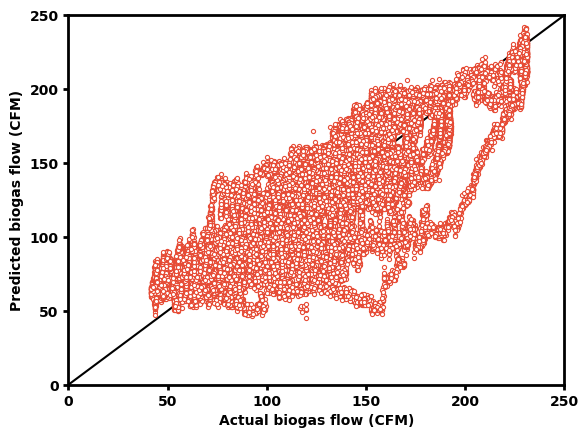

In [5]:
from matplotlib.font_manager import FontProperties

# Shuffle the data to plot randomly
permutation = np.random.permutation(len(y_test))
y_tests = y_test[permutation]
y_test_ann1s = y_test_ann1[permutation]

font_props = FontProperties(family='DejaVu Sans', weight='bold')
true_data = [0,250];
plt.plot(true_data, true_data, 'k',zorder=1)
# Plot the predicted values
plt.scatter(y_tests, y_test_ann1s, marker='o', s=9, linewidths=0.8, edgecolors='#E64B35FF', facecolors='w', label = 'prediction',zorder=2)
plt.xticks(rotation=0, fontproperties=font_props)
plt.yticks(fontproperties=font_props)

# Graph labels
plt.xlabel('Actual biogas flow (CFM)', fontproperties=font_props); plt.ylabel('Predicted biogas flow (CFM)', fontproperties=font_props); plt.xlim(0, 250)  # Set x-axis limits
plt.ylim(0, 250)  # Set y-axis limits

plt.gca().xaxis.set_tick_params(width=2)
plt.gca().yaxis.set_tick_params(width=2)
plt.gca().spines['top'].set_linewidth(2)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.savefig("Fig5B.png", bbox_inches='tight')

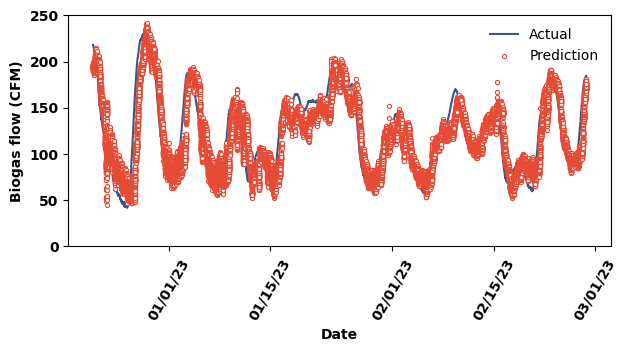

In [6]:
import matplotlib.dates as mdates
font_props = FontProperties(family='DejaVu Sans', weight='bold')

fig = plt.figure(figsize=(7, 3))

# Define the desired testing index range
start_index = 393408
end_index = 500000

x = data.index[start_index:end_index]
y1 = data['Forecast'][start_index:end_index]  
y2 = np.concatenate((y_train_ann1, y_test_ann1))[start_index:end_index]

plt.yticks(fontproperties=font_props)
plt.xticks(rotation=60,fontproperties=font_props)
plt.plot(x, y1, c='#3C5488FF', label='Actual',zorder=1)
plt.scatter(x,y2,marker='o', edgecolors='#E64B35FF', s=9, linewidths=0.8, facecolors='w', label='Prediction',zorder=2)
#plt.plot(x,y2, c='#E64B35FF', label='Prediction',zorder=2)
plt.xlabel('Date', fontproperties=font_props); plt.ylabel('Biogas flow (CFM)', fontproperties=font_props); 
plt.ylim(0, 250) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.legend(frameon=False)
plt.savefig('Fig5C.png', dpi=300, bbox_inches='tight')
plt.show()

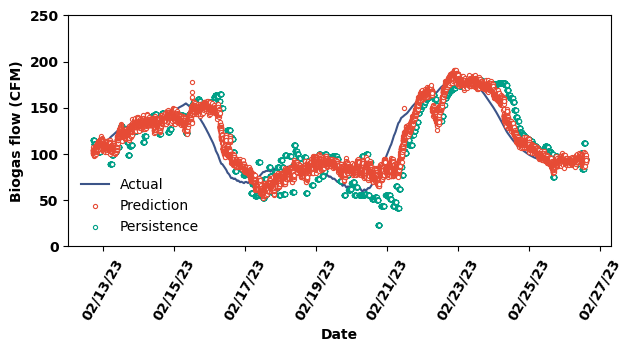

In [7]:
import matplotlib.dates as mdates
font_props = FontProperties(family='DejaVu Sans', weight='bold')

fig = plt.figure(figsize=(7, 3))

# Define the desired index range
start_index = 470000
end_index = 490000

x = data.index[start_index:end_index]
y1 = data['Forecast'][start_index:end_index]  
y2 = np.concatenate((y_train_ann1, y_test_ann1))[start_index:end_index]
y3 = data['Biogas_prev_hour_avg'][start_index:end_index]
y4_1 = data['Biogas_burner'] + data['Biogas_boiler']
y4 = y4_1[start_index:end_index]

plt.yticks(fontproperties=font_props)
plt.xticks(rotation=60,fontproperties=font_props)
plt.plot(x, y1, c='#3C5488FF', label='Actual',zorder=1)
plt.scatter(x,y2,marker='o', edgecolors='#E64B35FF', s=9, linewidths=0.8, facecolors='w', label='Prediction',zorder=3)
plt.scatter(x,y3,marker='o', edgecolors='#00A087', s=9, linewidths=0.8, facecolors='w', label='Persistence',zorder=2)
#plt.plot(x,y3,c='#00A087', label='Persistence',zorder=2)
plt.xlabel('Date', fontproperties=font_props); plt.ylabel('Biogas flow (CFM)', fontproperties=font_props); 
plt.ylim(0, 250) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.legend(frameon=False)
plt.show()

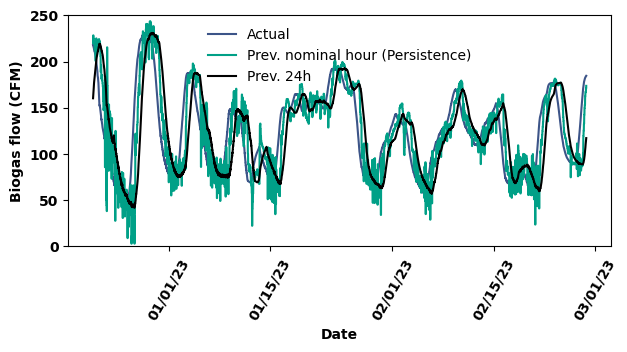

In [8]:
import matplotlib.dates as mdates
font_props = FontProperties(family='DejaVu Sans', weight='bold')

fig = plt.figure(figsize=(7, 3))

# Define the desired index range
start_index = 393408
end_index = 495000

x = data.index[start_index:end_index]
y1 = data['Forecast'][start_index:end_index]  
#y2 = np.concatenate((y_train_ann1, y_test_ann1))[start_index:end_index]
y3 = data['Biogas_prev_hour_avg'][start_index:end_index]
y4_1 = data['Biogas_prev_24h']
y4 = y4_1[start_index:end_index]

plt.yticks(fontproperties=font_props)
plt.xticks(rotation=60,fontproperties=font_props)
plt.plot(x, y1, c='#3C5488FF', label='Actual',zorder=1)
#plt.scatter(x,y2,marker='o', edgecolors='#E64B35FF', s=9, linewidths=0.8, facecolors='w', label='Prediction',zorder=3)
#plt.scatter(x,y3,marker='o', edgecolors='#00A087', s=9, linewidths=0.8, facecolors='w', label='Persistence',zorder=2)
plt.plot(x,y3,c='#00A087', label='Prev. nominal hour (Persistence)',zorder=2)
plt.plot(x,y4,c='k', label='Prev. 24h',zorder=3)
plt.xlabel('Date', fontproperties=font_props); plt.ylabel('Biogas flow (CFM)', fontproperties=font_props); 
plt.ylim(0, 250)  # Set y-axis limits
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.legend(frameon=False)
plt.savefig('FigS8.png', dpi=300, bbox_inches='tight')
plt.show()

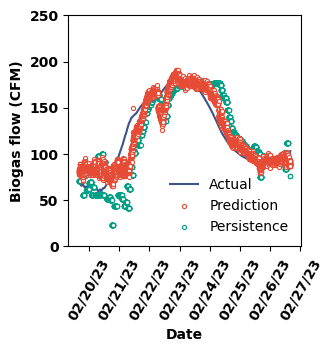

In [9]:
import matplotlib.dates as mdates
font_props = FontProperties(family='DejaVu Sans', weight='bold')

fig = plt.figure(figsize=(3, 3))

# Define the desired index range
start_index = 480000
end_index = 490080

x = data.index[start_index:end_index]
y1 = data['Forecast'][start_index:end_index]  
y2 = np.concatenate((y_train_ann1, y_test_ann1))[start_index:end_index]
y3 = data['Biogas_prev_hour_avg'][start_index:end_index]
y4_1 = data['Biogas_burner'] + data['Biogas_boiler']
y4 = y4_1[start_index:end_index]

plt.yticks(fontproperties=font_props)
plt.xticks(rotation=60,fontproperties=font_props)
plt.plot(x, y1, c='#3C5488FF', label='Actual',zorder=1)
plt.scatter(x,y2,marker='o', edgecolors='#E64B35FF', s=9, linewidths=0.8, facecolors='w', label='Prediction',zorder=3)
plt.scatter(x,y3,marker='o', edgecolors='#00A087', s=9, linewidths=0.8, facecolors='w', label='Persistence',zorder=2)
#plt.plot(x,y3,c='#00A087', label='Persistence',zorder=2)
plt.xlabel('Date', fontproperties=font_props); plt.ylabel('Biogas flow (CFM)', fontproperties=font_props); 
plt.ylim(0, 250)  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D'))
plt.legend(frameon=False)
plt.savefig('Fig5D.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
import shap
import time

shap.initjs()

X_train_summary = shap.kmeans(x_train_s, 10)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [11]:
# explain all the predictions in the test set
explainer = shap.KernelExplainer(model_ann1.predict, X_train_summary)

In [ ]:
testdf = pd.concat([x_test_s,y_test],axis=1)
testdf_sub = shap.sample(testdf,15000,random_state=42)
y_test_sub = testdf_sub['Forecast']
testing_features_sub = testdf_sub.drop('Forecast', axis=1)
shap_values = explainer.shap_values(testing_features_sub)

  0%|          | 0/15000 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


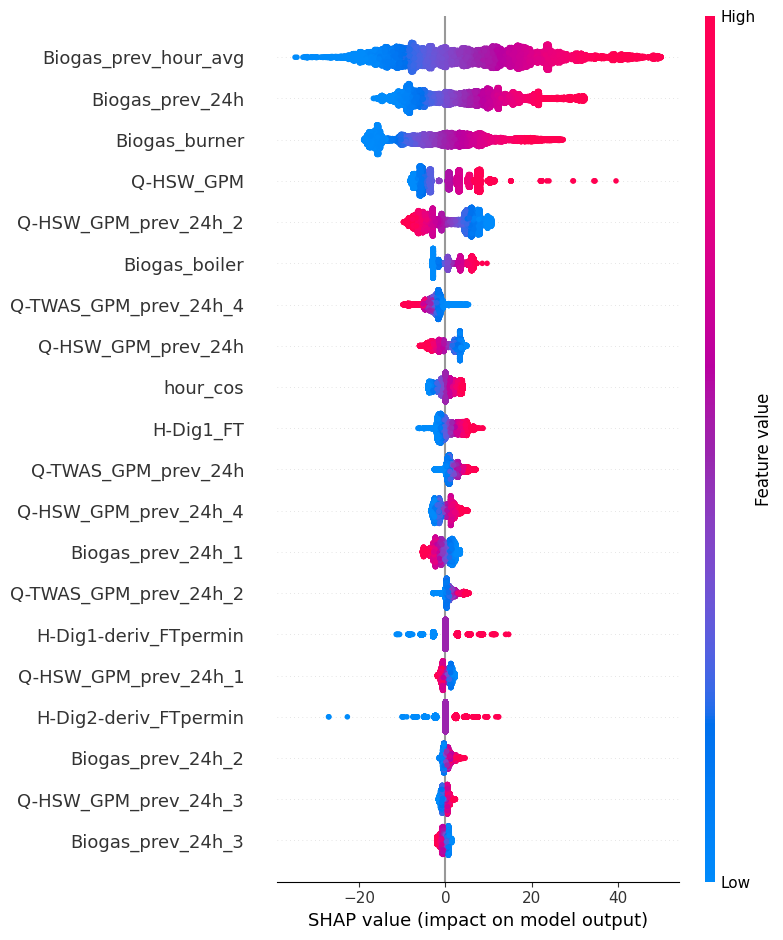

In [13]:
shap.summary_plot(shap_values, testing_features_sub, feature_names=x_train_s.columns)

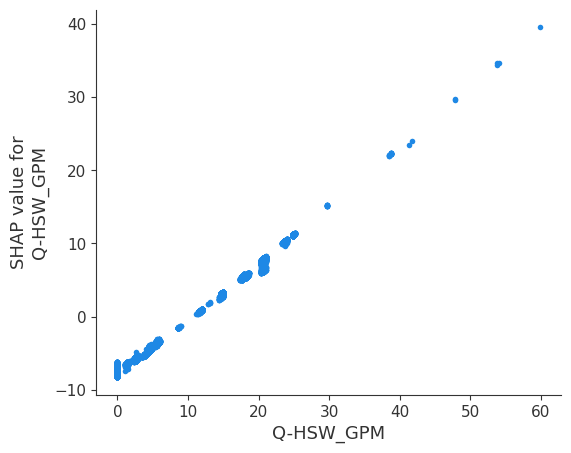

In [14]:
testing_features = pd.DataFrame(scaler.inverse_transform(testing_features_sub))
shap.dependence_plot(9, shap_values, testing_features, feature_names=x_train_s.columns, interaction_index=None)

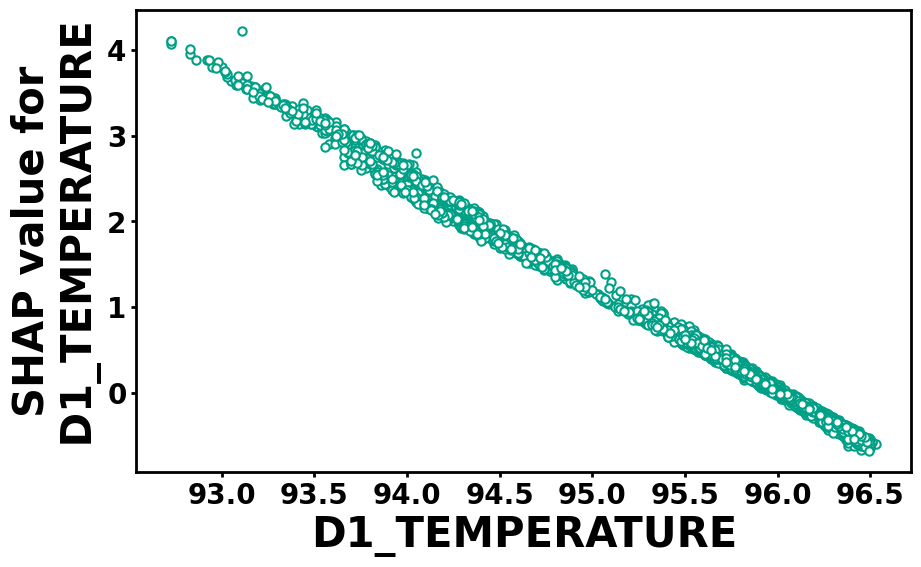

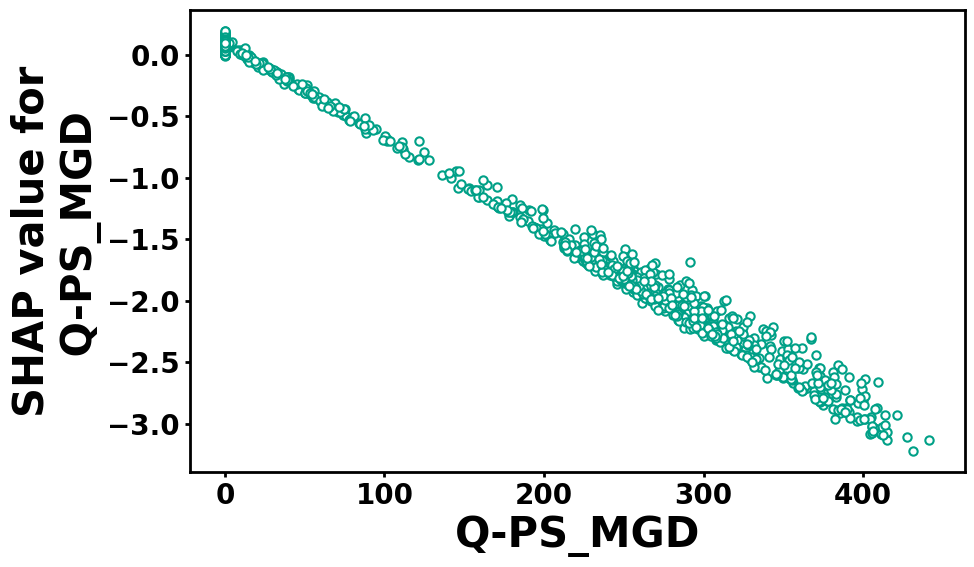

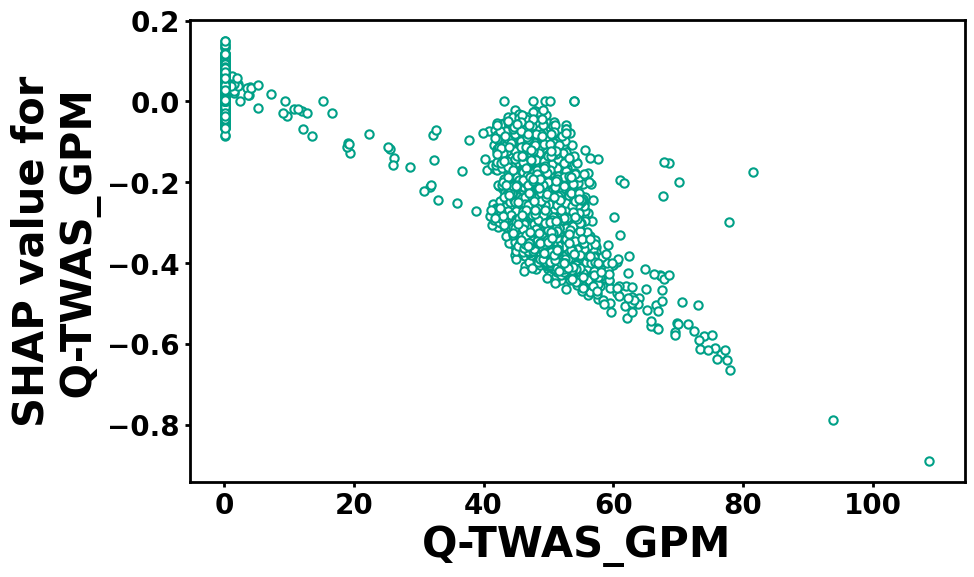

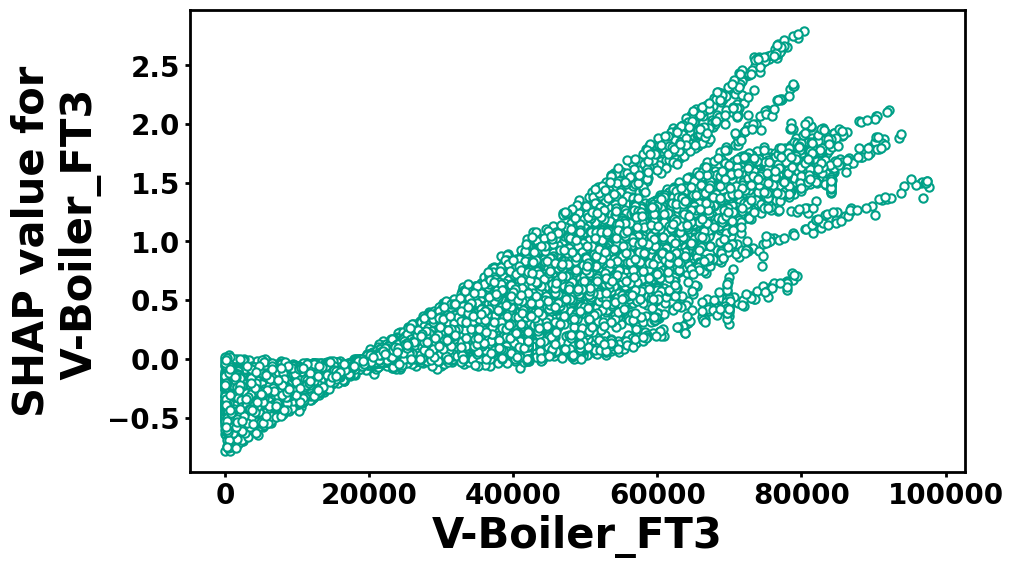

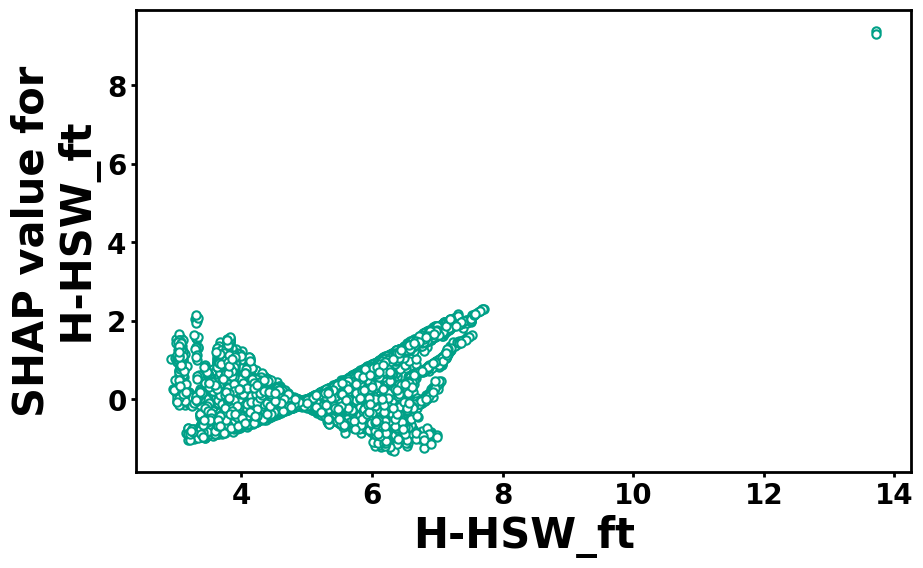

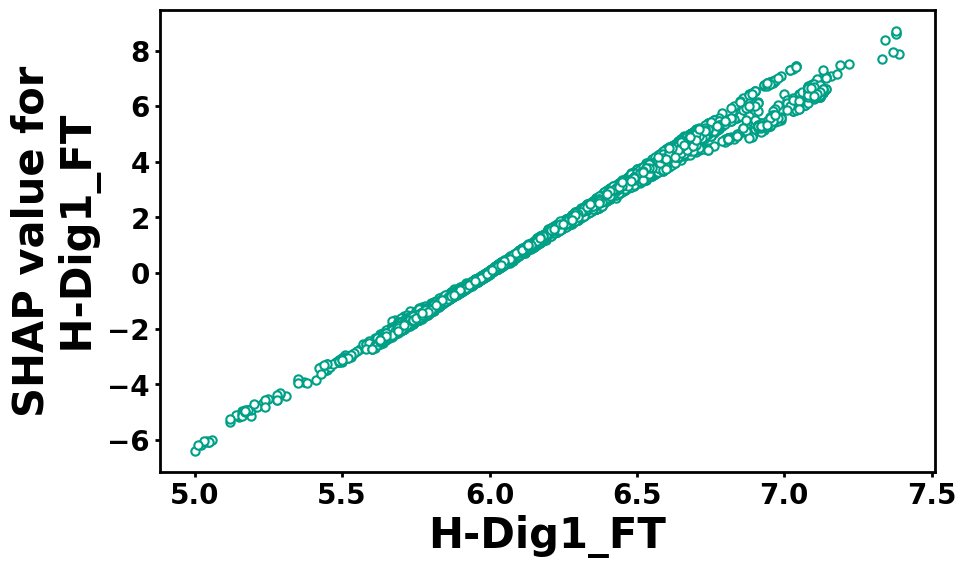

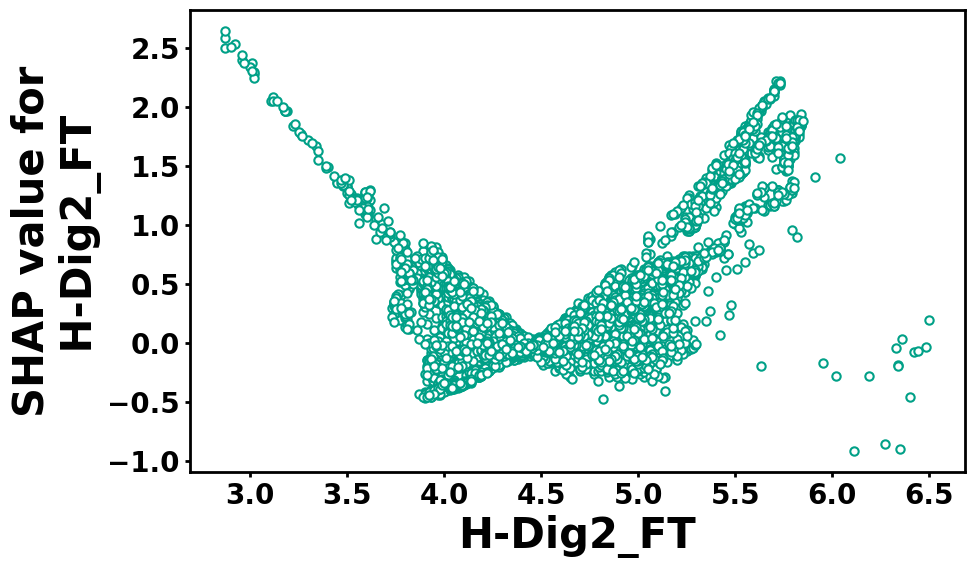

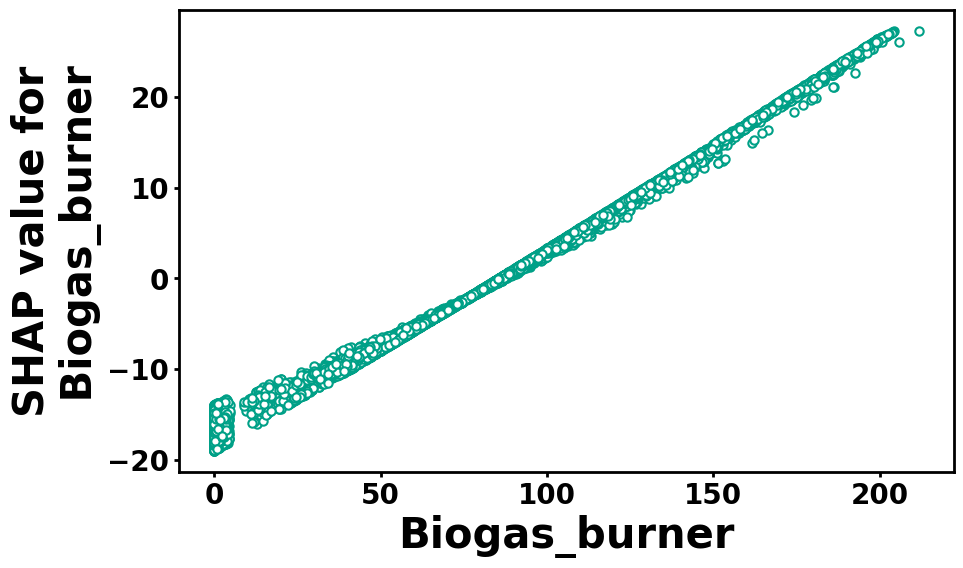

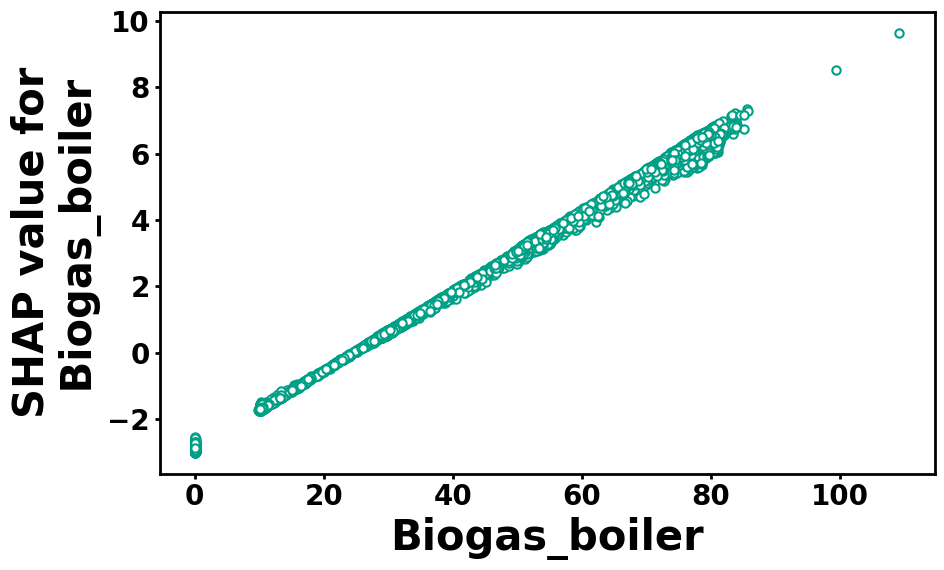

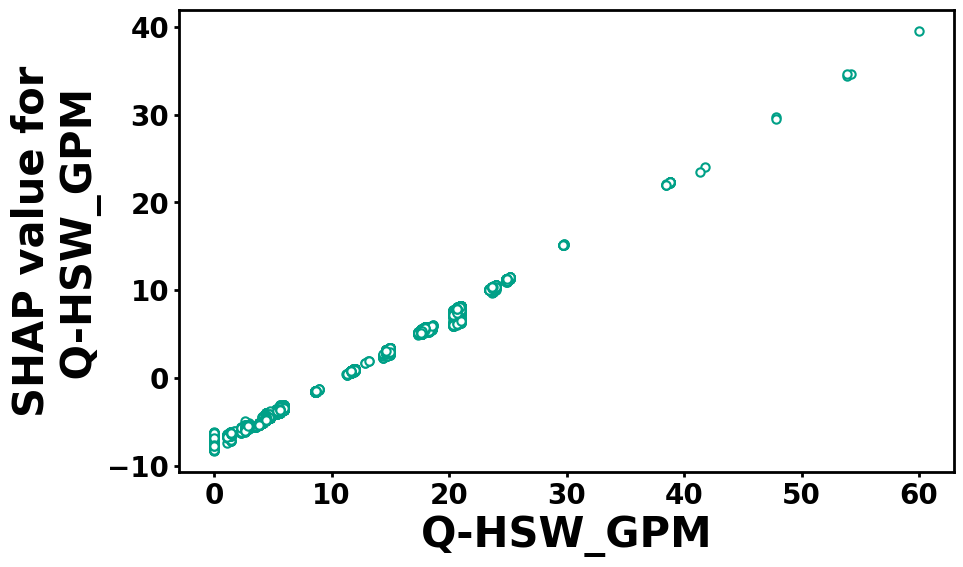

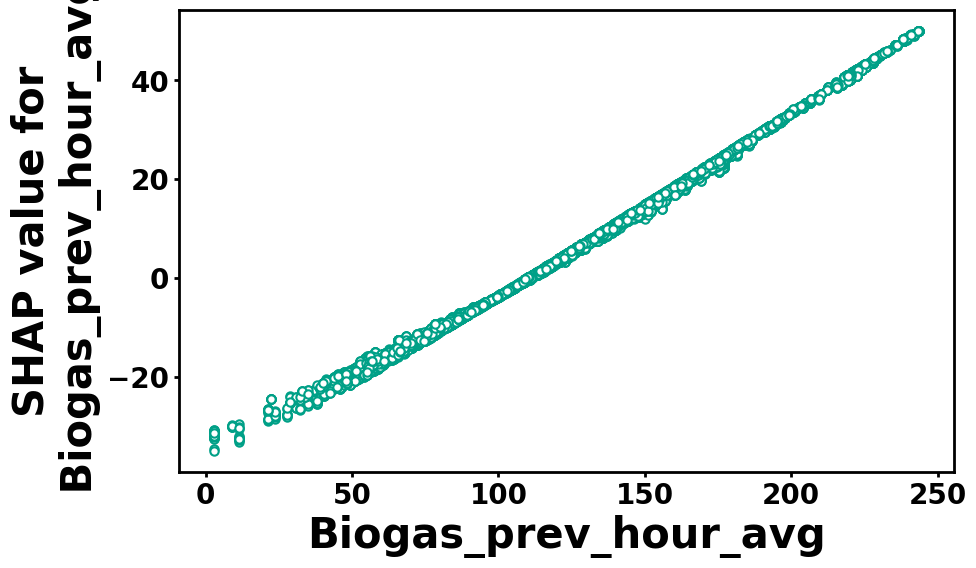

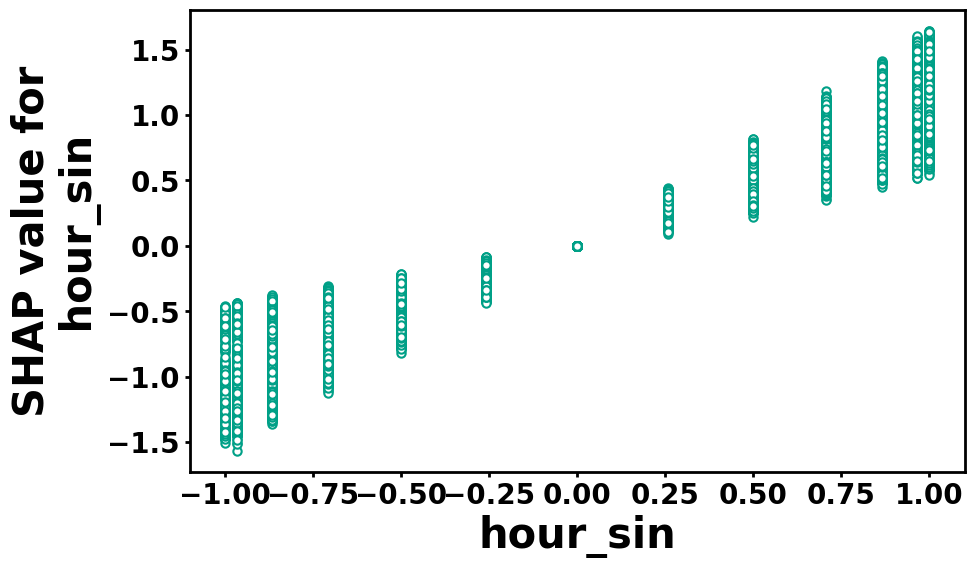

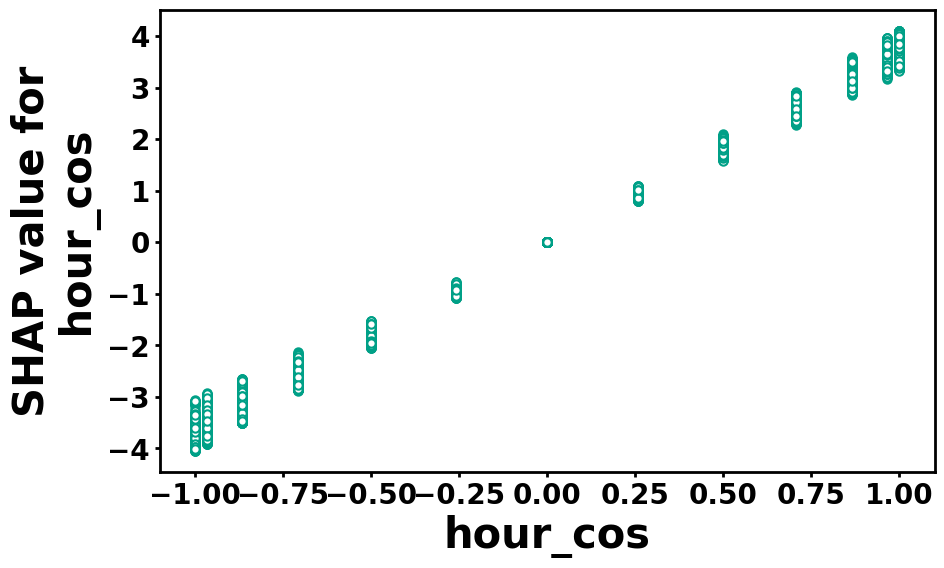

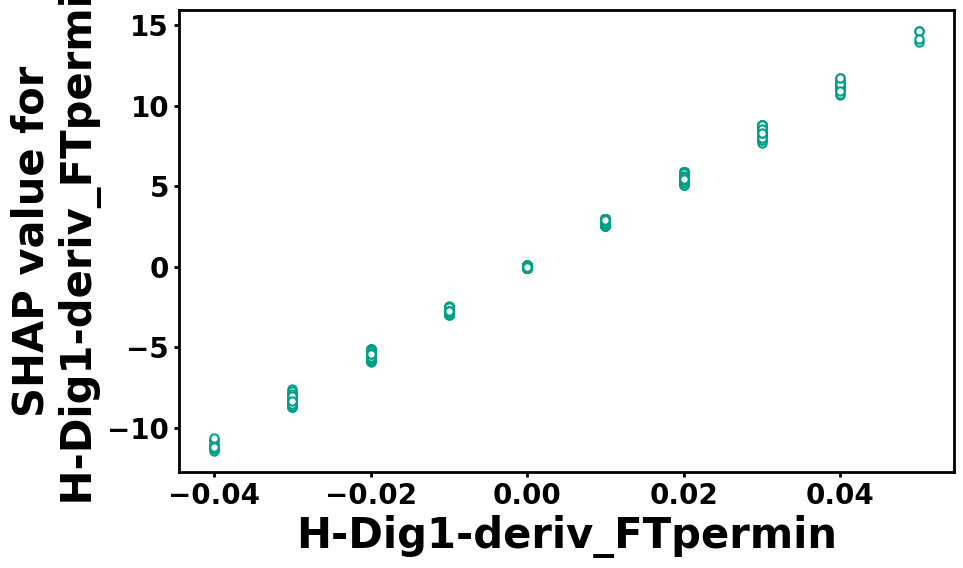

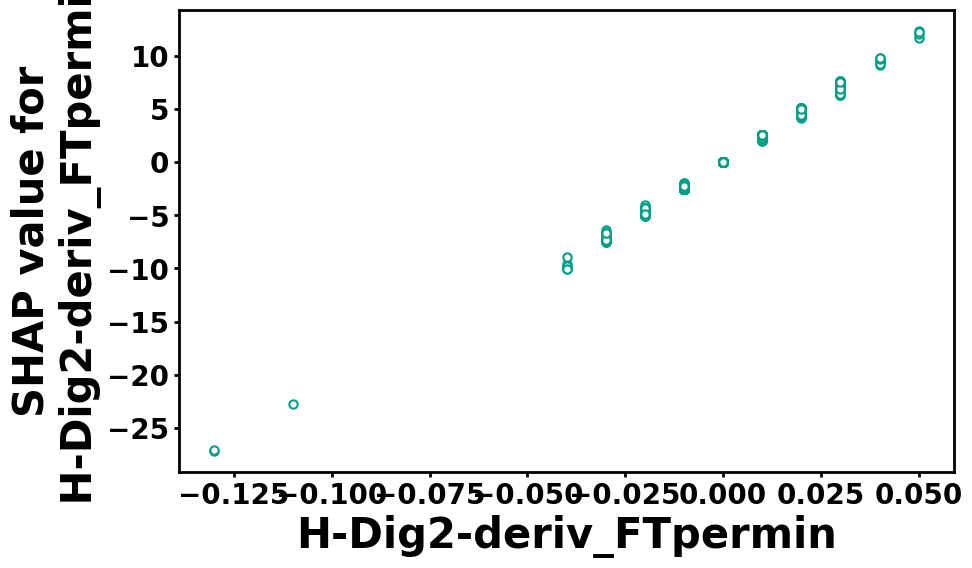

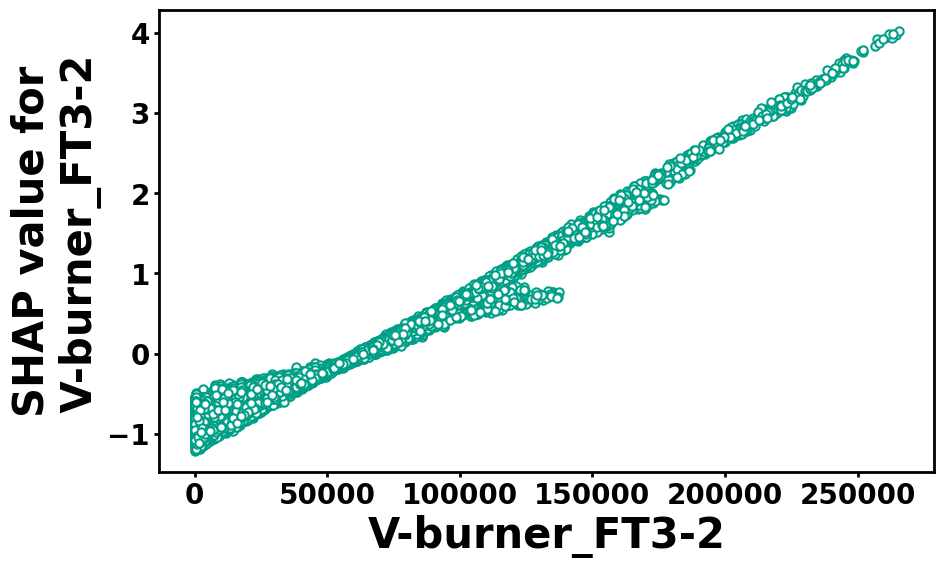

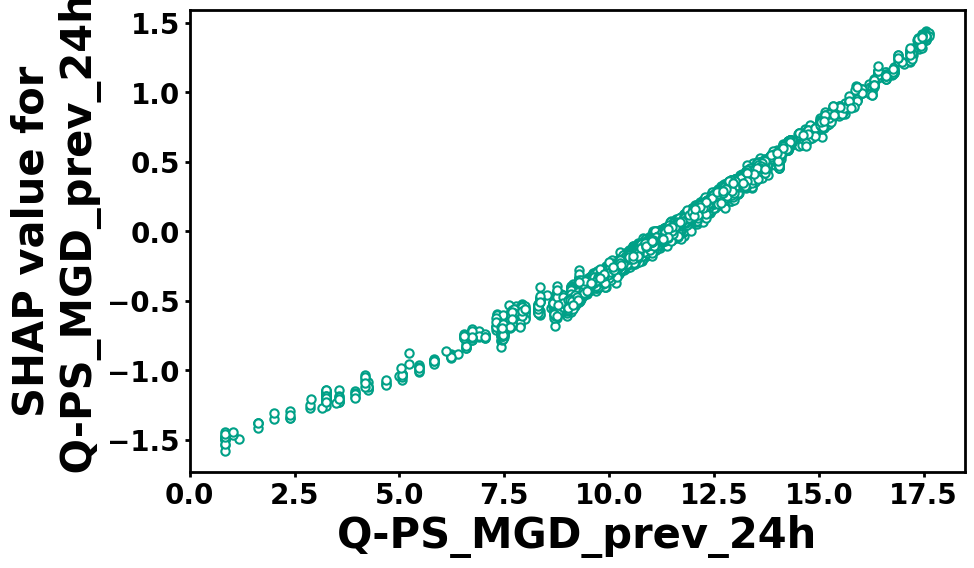

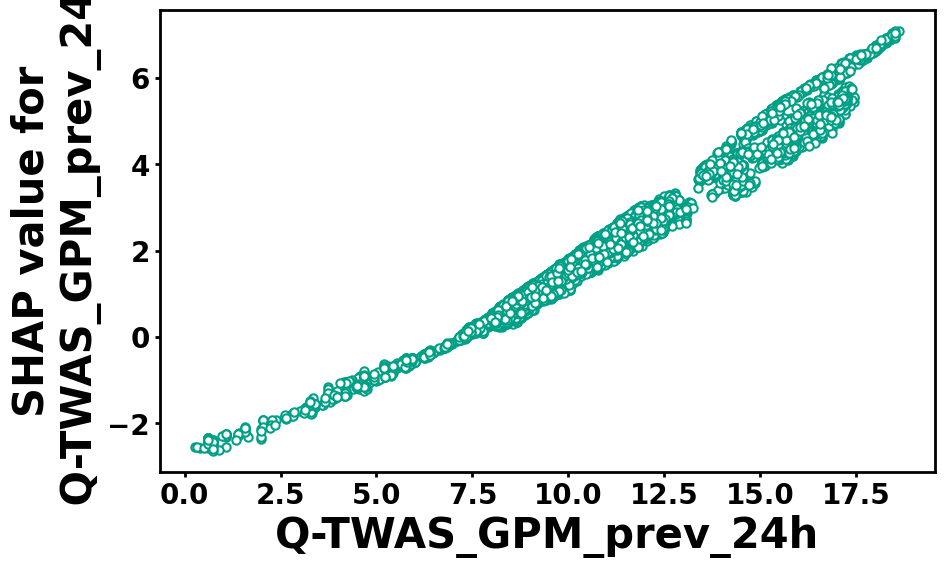

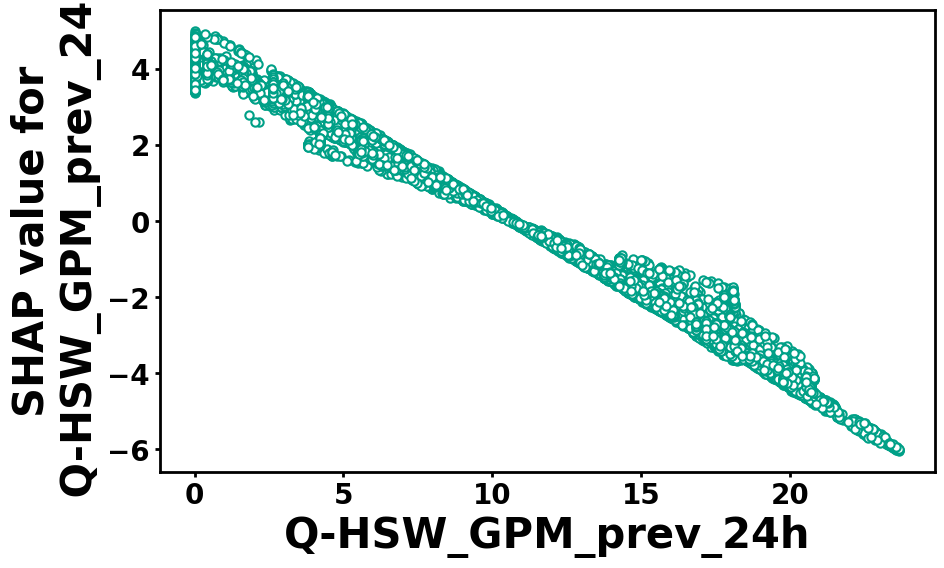

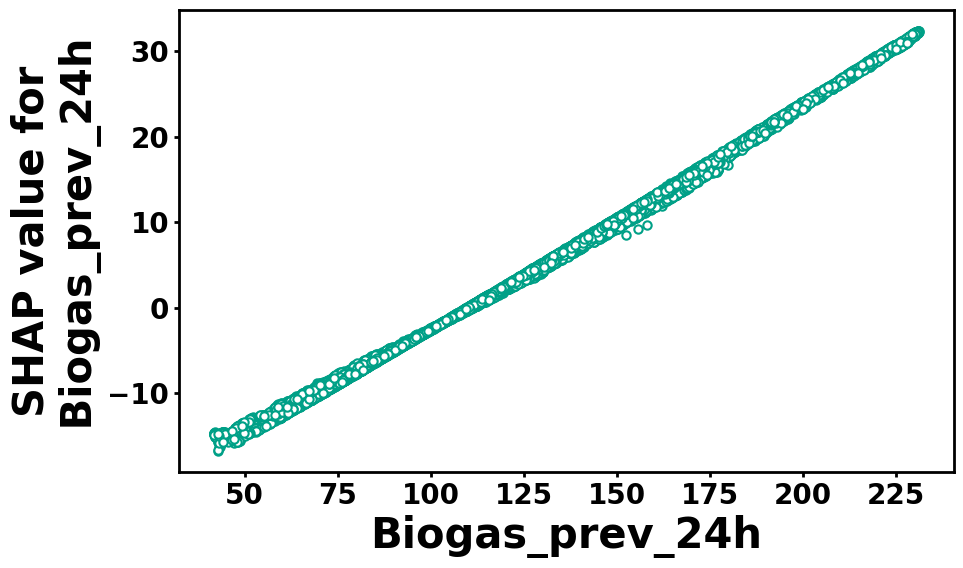

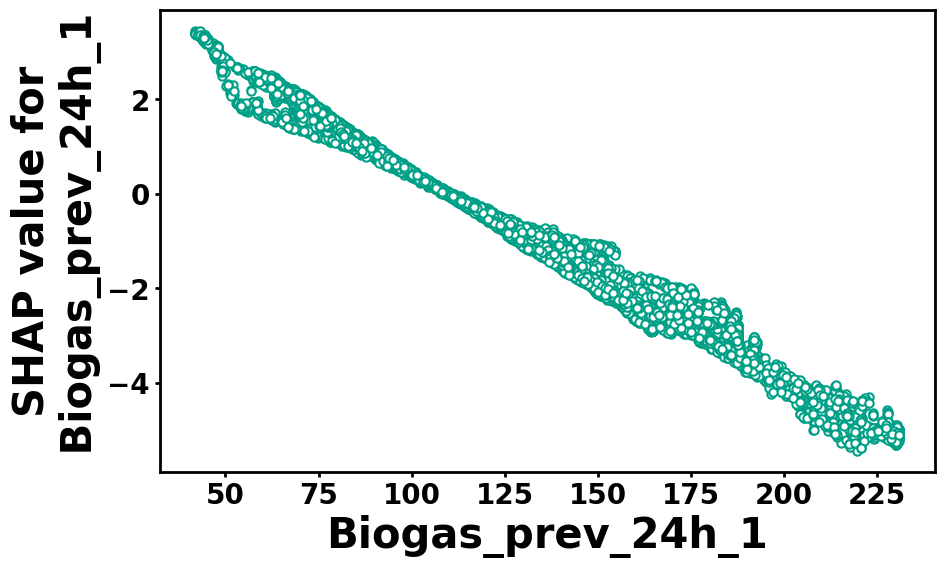

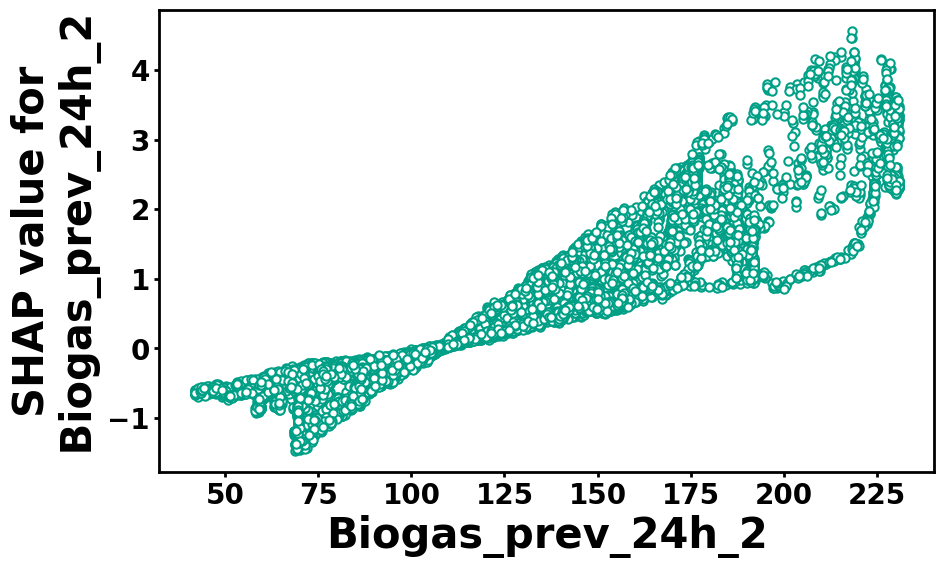

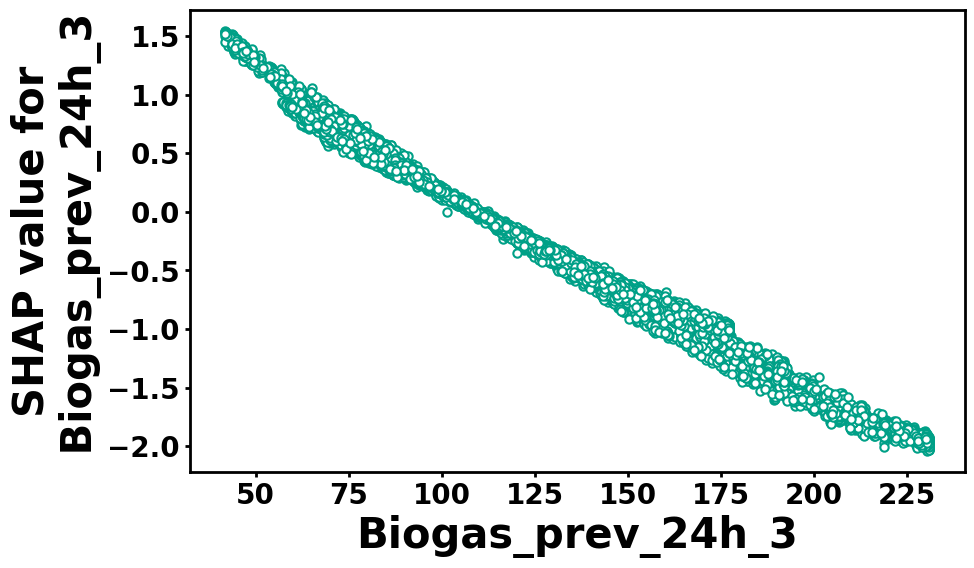

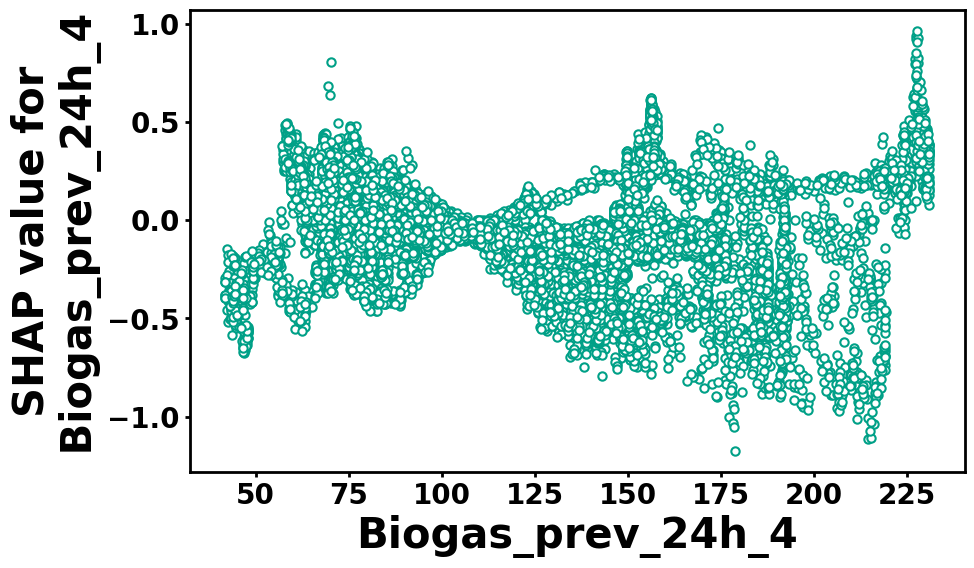

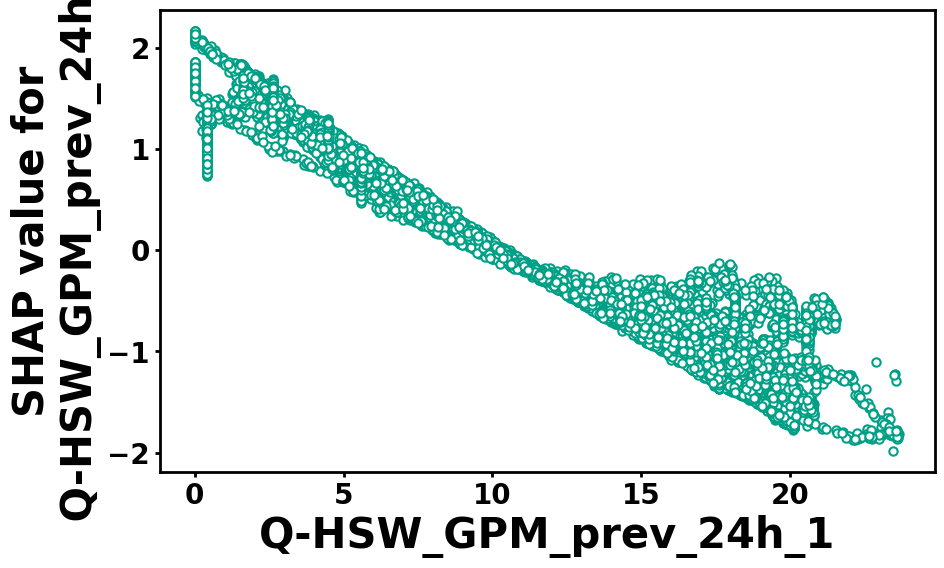

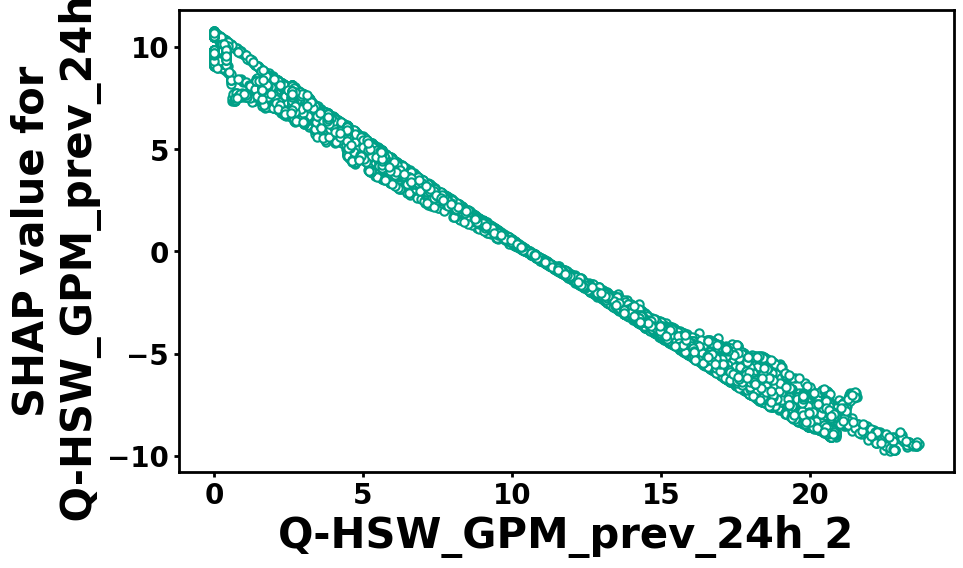

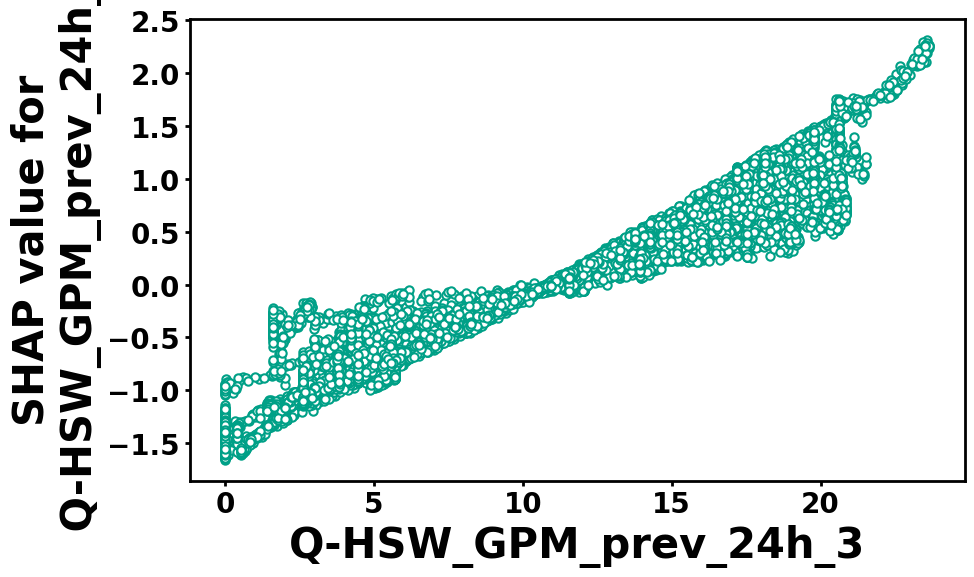

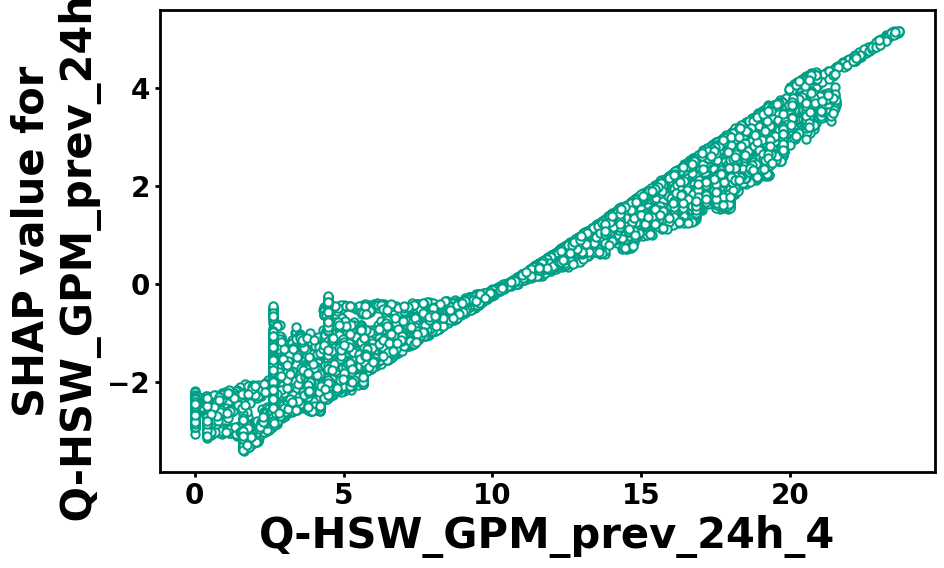

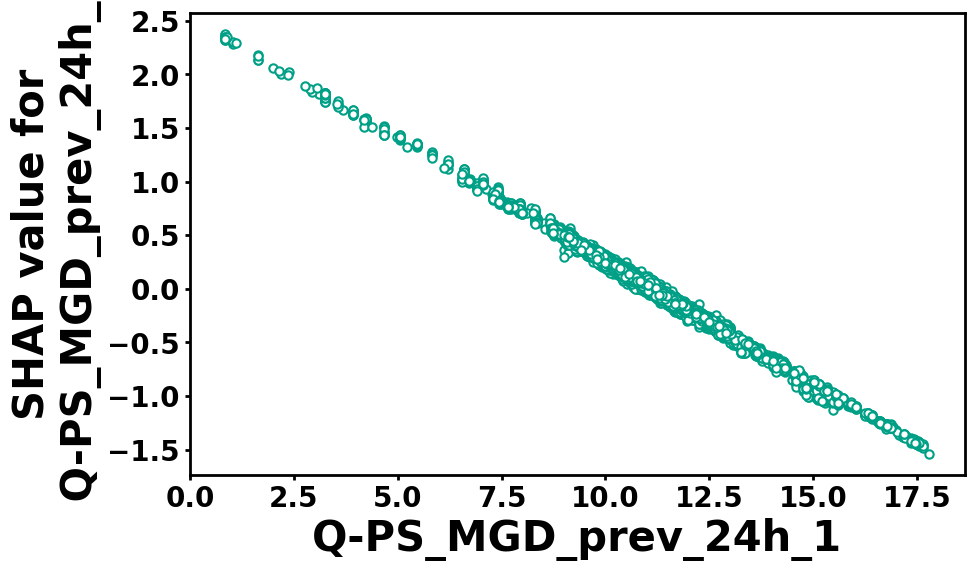

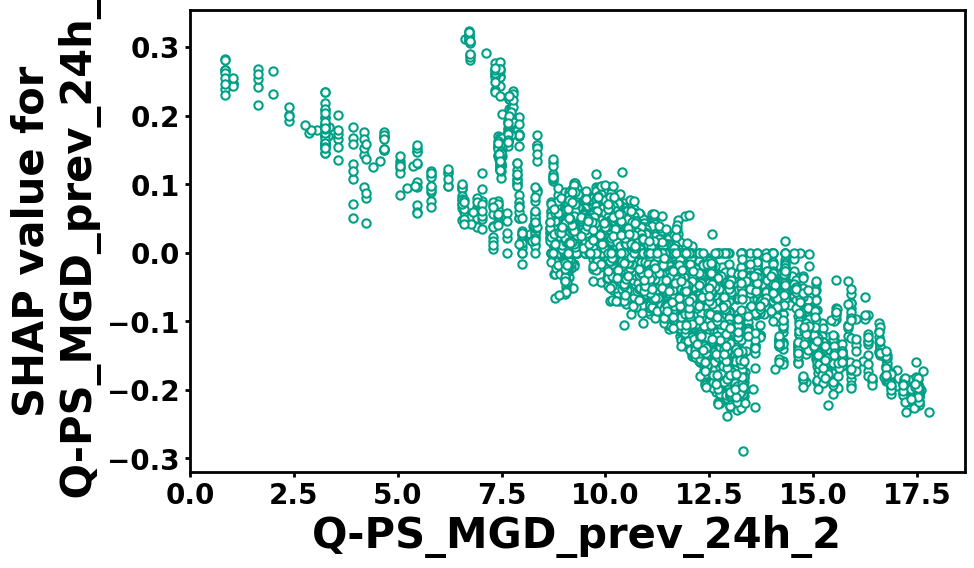

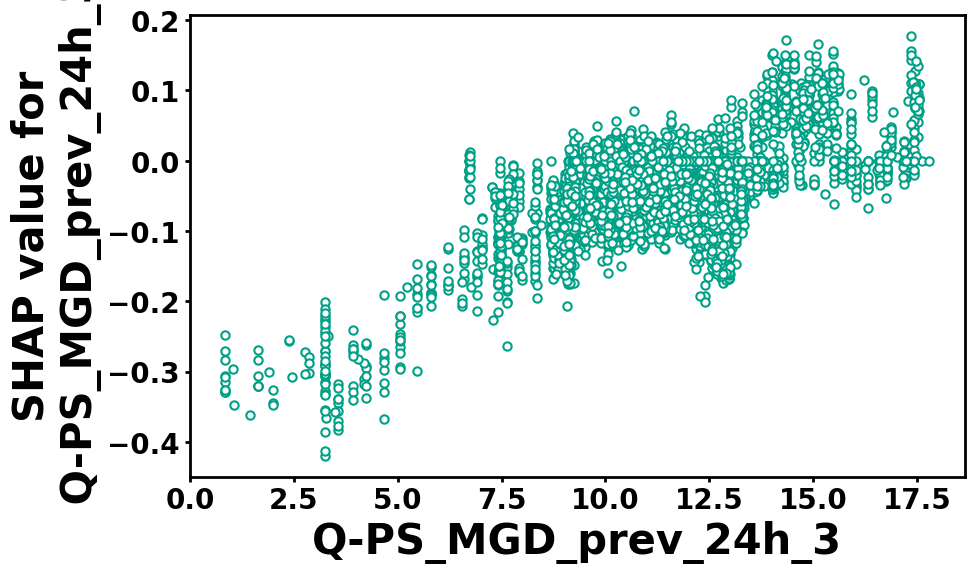

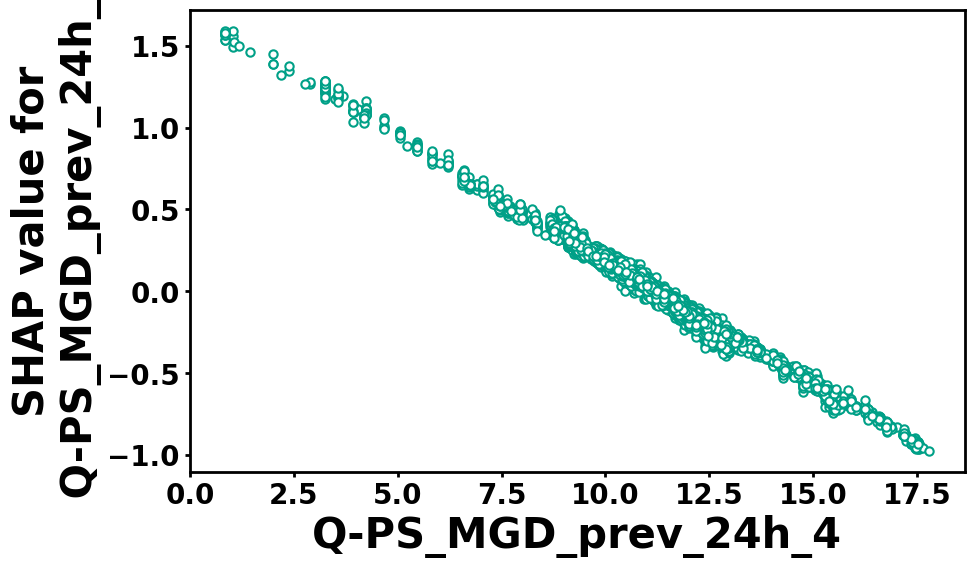

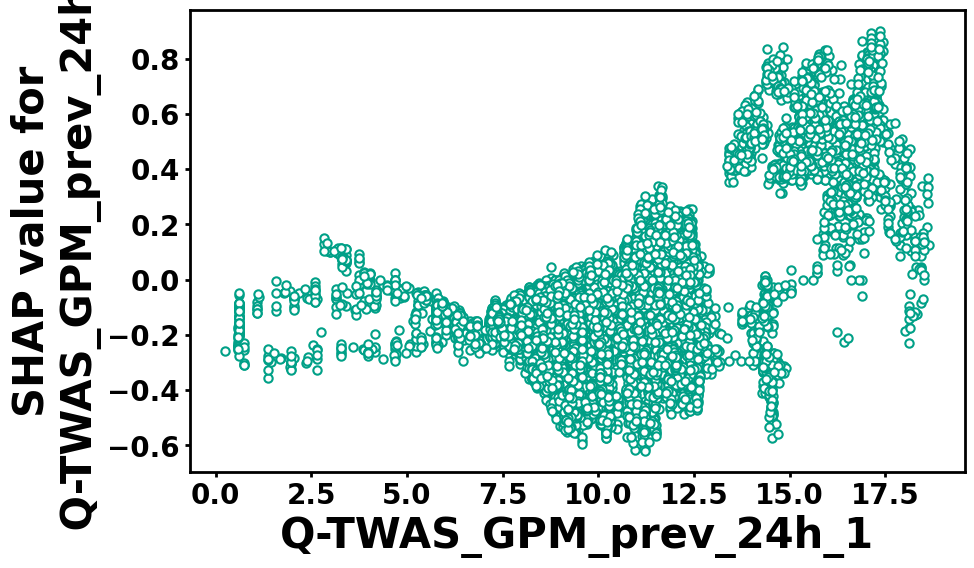

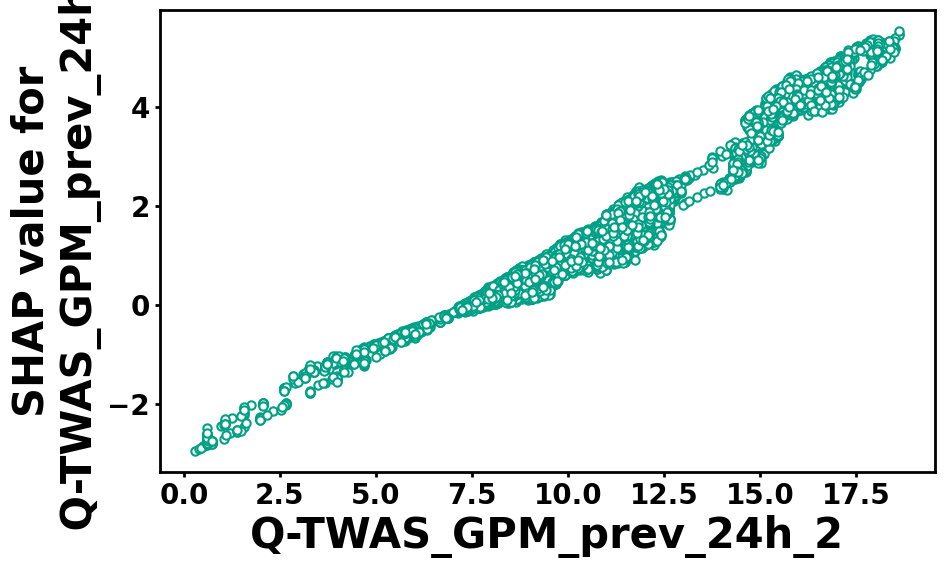

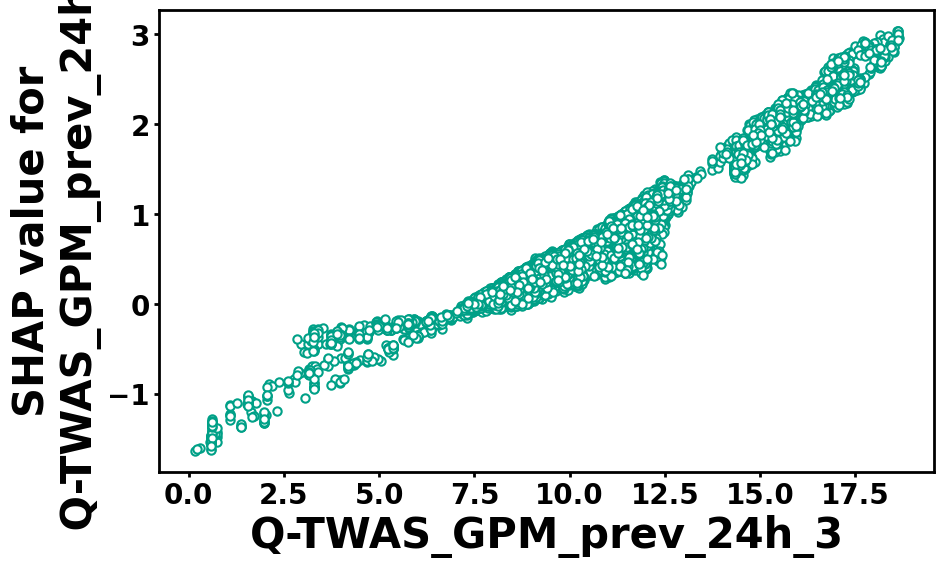

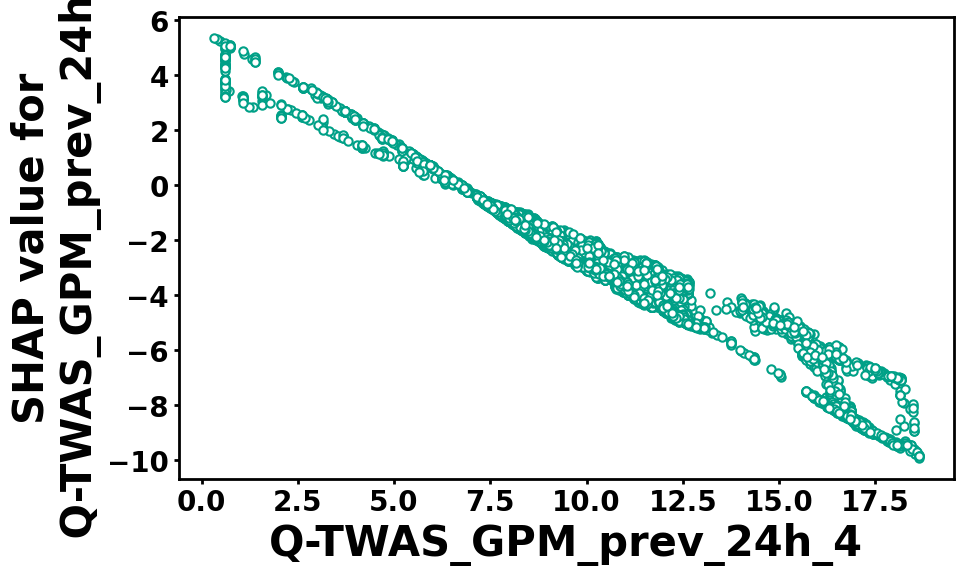

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

font_props1 = FontProperties(family='DejaVu Sans', weight='bold',size=30)
font_props = FontProperties(family='DejaVu Sans', weight='bold',size=20)
x_test_sub = scaler.inverse_transform(testing_features_sub)
for feature_index in range(len(testing_features_sub.columns)):
    try:
        fig, ax = plt.subplots(figsize=(10, 6), frameon=True)

        # Convert testing_features to a NumPy array
        testing_features_array = np.array(x_test_sub)

        # Scatter plot of SHAP values vs. testing_features
        scatter = ax.scatter(
            testing_features_array[:, feature_index],
            shap_values[:, feature_index],
            marker='o',
            edgecolors='#00A087FF',
            facecolors='w',
            linewidths=1.5
        )

        # Set plain rectangular frame
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        for spine in ax.spines.values():
            spine.set_linewidth(2)
        # Set x-axis label
        ax.set_xlabel(x_train_s.columns[feature_index], fontproperties=font_props1)

        # Set y-axis label
        ax.set_ylabel(f"SHAP value for\n {x_train_s.columns[feature_index]}", fontproperties=font_props1)

        # Reformat tick label fonts
        ax.tick_params(axis='both', which='both', labelsize=12, width=2)
        
        # Apply font_props to tick labels
        for label in ax.get_xticklabels():
            label.set_fontproperties(font_props)
        for label in ax.get_yticklabels():
            label.set_fontproperties(font_props)
        plt.savefig(f"plot_{feature_index}.png", bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error creating plot for feature {feature_index}: {e}")
